In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import yaml
import logging
import uuid
from importlib import import_module


try:
    from .exceptions import PluginError, ImageError, PluginTimeoutError, FileError, ConfigurationError
    from .base_plugin import BasePlugin
except ImportError:
    # support jupyter developement
    from exceptions import PluginError, ImageError, PluginTimeoutError, FileError, ConfigurationError
    from base_plugin import BasePlugin

In [3]:
logger = logging.getLogger(__name__)

In [4]:
import logging
import sys

# Configure logging to show in Jupyter Notebook
def setup_notebook_logging(level=logging.DEBUG):
    log_format = (
        '%(asctime)s [%(levelname)s] [%(name)s] '
        '[%(module)s.%(funcName)s] - %(message)s'
    )
    
    # Clear any existing handlers to prevent duplicate logging
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)

    # Set up logging for notebook
    logging.basicConfig(
        level=level,
        format=log_format,
        handlers=[logging.StreamHandler(sys.stdout)]
    )
    
    logging.getLogger(__name__).info("Notebook logging configured.")

# Run this cell to enable logging
setup_notebook_logging()

2024-12-30 13:32:03,562 [INFO] [__main__] [1243586361.setup_notebook_logging] - Notebook logging configured.


In [5]:
setup_notebook_logging(logging.INFO)

2024-12-30 13:32:04,487 [INFO] [__main__] [1243586361.setup_notebook_logging] - Notebook logging configured.


In [28]:
import yaml
from pathlib import Path
import logging


class PluginManager:
    def __init__(
        self,
        config: dict = None,
        plugin_path: Path = None,
        config_path: Path = None,
        main_schema_file: str = None,
        plugin_schema_file: str = None,
        max_plugin_failures: int = 5,
    ):
        self._config = {}
        self._configured_plugins = []        
        self.plugin_path = plugin_path
        self.config_path = config_path
        self.main_schema_file = main_schema_file
        self.plugin_schema_file = plugin_schema_file
        self._main_schema = None
        self._plugin_schema = None
        self.max_plugin_failures = max_plugin_failures
        self.plugin_failures = {}

        # Initialize config if provided
        if config:
            self.config = config

        logger.debug("PluginManager initialized with default values.")

    @property
    def config(self):
        return self._config

    @config.setter
    def config(self, value):
        if not isinstance(value, dict):
            raise TypeError("Config must be a dictionary.")
        
        schema = self.main_schema
        if schema:
            logger.info("Validating config against main schema...")
            self._validate_config(value, schema)

        self._config = value
        logger.info("Configuration successfully updated.")

    @property
    def config_path(self):
        return self._config_path

    @config_path.setter
    def config_path(self, value):
        if not value:
            logger.warning("Config path set to None. Schema loading disabled.")
            self._config_path = None
            return

        if not isinstance(value, Path):
            value = Path(value)

        if not value.is_dir():
            raise FileNotFoundError(f"Config directory not found at {value}")

        self._config_path = value
        self._main_schema = None
        self._plugin_schema = None
        logger.info(f"Config path set to {self._config_path}")

    @property
    def plugin_path(self):
        return self._plugin_path

    @plugin_path.setter
    def plugin_path(self, value):
        if not value:
            logger.warning("Plugin path set to None.")
            self._config_path = None
            return

        if not isinstance(value, Path):
            value = Path(value)

        if not value.is_dir():
            raise FileNotFoundError(f"Plugin directory not found at {value}")

        self._plugin_path = value
        logger.info(f"Plugin path set to {self._plugin_path}")
    
    @property
    def main_schema(self):
        if self._main_schema is None:
            if not self._config_path or not self.main_schema_file:
                logger.warning("Config path or main schema file not set.")
                return {}

            schema_file = self._config_path / self.main_schema_file
            if not schema_file.is_file():
                raise FileNotFoundError(f"Main schema file not found at {schema_file}")

            logger.info(f"Loading main config schema from {schema_file}")
            with open(schema_file, "r") as f:
                self._main_schema = yaml.safe_load(f)
        return self._main_schema

    @property
    def plugin_schema(self):
        if self._plugin_schema is None:
            if not self._config_path or not self.plugin_schema_file:
                logger.warning("Config path or plugin schema file not set.")
                return {}

            schema_file = self._config_path / self.plugin_schema_file
            if not schema_file.is_file():
                raise FileNotFoundError(f"Plugin schema file not found at {schema_file}")

            logger.info(f"Loading plugin schema from {schema_file}")
            with open(schema_file, "r") as f:
                self._plugin_schema = yaml.safe_load(f)
        return self._plugin_schema

    @property
    def configured_plugins(self):
        return self._configured_plugins

    @configured_plugins.setter
    def configured_plugins(self, value):
        if not isinstance(value, list):
            raise TypeError("configured_plugins must be a list of plugin configurations.")
    
        for plugin_entry in value:
            plugin_name = plugin_entry['plugin']
            base_config = plugin_entry['base_config']
    
            # 1. Validate Against Global Plugin Schema (Mandatory)
            global_schema = self.plugin_schema.get('plugin_config', {})
            logger.info("=" * 40)
            logger.info(f"Validating {plugin_name} against global schema...")
            self._validate_config(base_config, global_schema)

            # Assign UUID and final setup
            plugin_uuid = str(uuid.uuid4())[:8]
            base_config['uuid'] = plugin_uuid
            logger.info(f"Assigned UUID {plugin_uuid} to plugin {plugin_name}.")
    
            if not base_config.get('name'):
                base_config['name'] = f"{plugin_name}-{plugin_uuid}"
                logger.info(f"Set default plugin name to {base_config['name']}.")
    
        self._configured_plugins = value
        logger.info("All plugins validated and configured.")
        
        self._configured_plugins = value
        logger.info("configured_plugins successfully validated and set.")
    
    def reload_schemas(self):
        """
        Force reload of main and plugin schemas.
        """
        self._main_schema = None
        self._plugin_schema = None
        logger.info("Schemas reloaded.")

    def _load_plugin_schema(self, plugin_name):
        """
        Load the plugin-specific schema if it exists.
        """
        plugin_dir = self.plugin_path / plugin_name
        schema_file = plugin_dir / self.plugin_schema_file  # e.g., plugin_schema.yaml
    
        if schema_file.exists():
            logger.info(f"Loading plugin-specific schema for {plugin_name} from {schema_file}...")
            with open(schema_file, "r") as f:
                return yaml.safe_load(f)
        else:
            logger.info(f"No plugin-specific schema found for {plugin_name}. Skipping additional validation.")
            return {}
    
    def _validate_config(self, config, schema):
        """
        Validate configuration against a schema.
        
        Args:
            config (dict): Configuration to validate.
            schema (dict): Schema to validate against.

        Raises:
            ValueError: If the config does not match the schema.
        """
        errors = []
        
        for key, params in schema.items():
            description = params.get('description', 'No description available')
            if key not in config:
                if params.get('required', False):
                    errors.append(f"{key} is required but missing. Description: {description}")
                else:
                    config[key] = params.get('default')
            else:
                value = config[key]
                expected_type = eval(params['type'])

                # Type check
                if not isinstance(value, expected_type):
                    errors.append(f"{key} must be of type {expected_type.__name__} (got {type(value).__name__}). Description: {description}")

                # Allowed values check
                allowed = params.get('allowed')
                if allowed and value not in allowed:
                    errors.append(f"{key} must be one of {allowed} (got {value}). Description: {description}")

        if errors:
            raise ValueError("Config validation failed:\n" + "\n".join(errors))

        logger.info("Config passed schema validation.")

    def load_plugins(self):
        """
        Locate and load plugins based on the configured_plugins property.
        Only load plugins that pass global and plugin-specific schema validation.
        """
        self.active_plugins = []
        self.dormant_plugins = []
        
        for entry in self.configured_plugins:
            plugin_name = entry['plugin']
            base_config = entry['base_config']
            plugin_params = entry.get('plugin_params', {})  # Defaults to empty if missing
        
            try:
                # 1. Validate Against Plugin-Specific Schema
                plugin_specific_schema = self._load_plugin_schema(plugin_name)
                if plugin_specific_schema:
                    logger.info(f"Validating {plugin_name} against its specific schema...")
                    self._validate_config(plugin_params, plugin_specific_schema)
    
                # 2. Import the plugin module dynamically
                module = import_module(f'plugins.{plugin_name}')
        
                # 3. Attach the update function from the module
                if hasattr(module.plugin, 'update_function'):
                    base_config['update_function'] = module.plugin.update_function
                else:
                    logger.warning(f"{plugin_name}: update_function not found. Skipping plugin.")
                    continue
        
                # 4. Load layout (if specified)
                if 'layout' in base_config:
                    layout_name = base_config['layout']
                    if hasattr(module.layout, layout_name):
                        layout = getattr(module.layout, layout_name)
                        base_config['layout'] = layout
                    else:
                        raise AttributeError(f"Layout '{layout_name}' not found in {plugin_name}")
                else:
                    logger.warning(f"{plugin_name} is missing a configured layout. Skipping plugin.")
                    continue
        
                # 5. Instantiate BasePlugin and pass configurations
                plugin_instance = BasePlugin(
                    **base_config,
                    config=plugin_params,  # Pass plugin_params as config
                )
                plugin_instance.update_function = base_config['update_function']
        
                # 6. Sort into active or dormant lists
                if base_config.get('dormant', False):
                    self.dormant_plugins.append(plugin_instance)
                    logger.info(f"Loaded dormant plugin: {plugin_name}")
                else:
                    self.active_plugins.append(plugin_instance)
                    logger.info(f"Loaded active plugin: {plugin_name}")
            except ValueError as e:
                logger.warning(f"{plugin_name}: Plugin-specific schema validation failed: {e}")
            except ModuleNotFoundError as e:
                logger.warning(f"{plugin_name} failed to load due to error: {e}. Skipping plugin.")
                continue
            except Exception as e:
                logger.error(f"Unexpected error loading {plugin_name}: {e}")
                continue
        
        logger.info(f"Loaded {len(self.active_plugins)} active plugins and {len(self.dormant_plugins)} dormant plugins.")
        
    def update_plugins(self):
        """
        Update all active plugins and check dormant plugins for activation.
        Dormant plugins that activate become high-priority and interrupt the display cycle.
        """
        # Process both active and dormant plugins together
        all_plugins = self.active_plugins + self.dormant_plugins
    
        for plugin in list(all_plugins):
            # Skip if plugin is still in cool-down (refresh interval not passed)
            if not plugin.ready_for_update:
                logger.debug(f"Plugin")
                continue
            
            logger.info(f"Updating plugin: {plugin.name}")
            try:
                success = plugin.update()
                
                # Reset failure count on success
                if success:
                    self.plugin_failures[plugin.uuid] = 0
                    
                    # Handle dormant plugin activation
                    if plugin.high_priority and plugin in self.dormant_plugins:
                        logger.info(f"{plugin.name} activated as high-priority.")
                        # consider another way to do this; create a property called active plugin
                        self.active_plugins.insert(0, plugin)
                        self.dormant_plugins.remove(plugin)
                        
                        # Interrupt to prioritize this plugin
                        break
                else:
                    self._handle_plugin_failure(plugin)
            
            except Exception as e:
                logger.error(f"Error updating {plugin.name}: {e}")
                self._handle_plugin_failure(plugin)

    def _handle_plugin_failure(self, plugin):
        uuid = plugin.config['uuid']
        self.plugin_failures[uuid] = self.plugin_failures.get(uuid, 0) + 1
        
        if self.plugin_failures[uuid] >= self.max_plugin_failures:
            logger.warning(f"{plugin.name} removed after {self.max_plugin_failures} consecutive failures.")
            self.active_plugins.remove(plugin)
        else:
            logger.warning(f"{plugin.name} failed ({self.plugin_failures[uuid]}/{self.max_plugin_failures}).")

    def remove_plugin_by_uuid(self, plugin_uuid):
        """
        Remove a plugin from active or dormant lists based on UUID.
        """
        for plugin_list in [self.active_plugins, self.dormant_plugins]:
            for plugin in plugin_list:
                if plugin.uuid == plugin_uuid:
                    plugin_list.remove(plugin)
                    logger.info(f"Removed plugin {plugin.name} (UUID: {plugin_uuid})")
                    return True
        
        logger.warning(f"Plugin with UUID {plugin_uuid} not found.")
        return False

In [15]:
! ln -s ../plugins ./

ln: failed to create symbolic link './plugins': File exists


In [29]:
m = PluginManager()

m.plugin_path = './plugins/'
m.config_path = '../config/'
m.main_schema_file = 'plugin_manager_schema.yaml'
m.plugin_schema_file = 'plugin_schema.yaml'

config = {
    'screen_mode': 'L',
    'resolution': (160, 190),
}

configured_plugins = [
    {'plugin': 'basic_clock',
         'base_config': {
            'name': 'Basic Clock',
            'duration': 100,
            # 'refresh_interval': 60,
            'dormant': False,
            'layout': 'layout',
         }
    },
    {'plugin': 'word_clock',
        'base_config':{
            'name': 'Word Clock',
            'duration': 130,
            'refresh_interval': 60,
            'layout': 'layout',
        },
        'plugin_params': {
            'foo': 'bar',
            'spam': 7,
            'username': 'Monty'}
    },
    {'plugin': 'xkcd_comic',
        'base_config': {
            'name': 'XKCD',
            'duration': 200,
            'refresh_interval': 1800,
            'dormant': False,
            'layout': 'layout'
        },
        'plugin_params':{
            'max_x': 800,
            'max_y': 600,
            'resize': False,
            'max_retries': 5
        }
             
    }
]
m.config = config
m.configured_plugins = configured_plugins

m.configured_plugins

m.load_plugins()

2024-12-30 15:49:34,004 [WARNING] [__main__] [3947808393.plugin_path] - Plugin path set to None.
2024-12-30 15:49:34,005 [WARNING] [__main__] [3947808393.config_path] - Config path set to None. Schema loading disabled.
2024-12-30 15:49:34,008 [INFO] [__main__] [3947808393.plugin_path] - Plugin path set to plugins
2024-12-30 15:49:34,010 [INFO] [__main__] [3947808393.config_path] - Config path set to ../config
2024-12-30 15:49:34,013 [INFO] [__main__] [3947808393.main_schema] - Loading main config schema from ../config/plugin_manager_schema.yaml
2024-12-30 15:49:34,025 [INFO] [__main__] [3947808393.config] - Validating config against main schema...
2024-12-30 15:49:34,026 [INFO] [__main__] [3947808393._validate_config] - Config passed schema validation.
2024-12-30 15:49:34,028 [INFO] [__main__] [3947808393.config] - Configuration successfully updated.
2024-12-30 15:49:34,030 [INFO] [__main__] [3947808393.plugin_schema] - Loading plugin schema from ../config/plugin_schema.yaml
2024-12-30

In [33]:
m.update_plugins()

2024-12-30 15:52:50,806 [INFO] [__main__] [3947808393.update_plugins] - Updating plugin: Basic Clock
2024-12-30 15:52:50,807 [INFO] [base_plugin] [base_plugin.update] - Basic Clock - Running update (force=False)...
2024-12-30 15:52:50,809 [INFO] [base_plugin] [base_plugin.update] - Basic Clock - Update successful.
2024-12-30 15:52:50,820 [INFO] [base_plugin] [base_plugin.update] - Basic Clock - Image updated via layout.concat().
2024-12-30 15:52:50,822 [INFO] [__main__] [3947808393.update_plugins] - Updating plugin: Word Clock
2024-12-30 15:52:50,824 [INFO] [base_plugin] [base_plugin.update] - Word Clock - Running update (force=False)...
2024-12-30 15:52:50,826 [INFO] [plugins.word_clock.plugin] [plugin.update_function] - update_function for Word Clock
{'wordtime': "It is almost Ten 'Til Four", 'time': '15:52'}
2024-12-30 15:52:50,828 [INFO] [base_plugin] [base_plugin.update] - Word Clock - Update successful.
2024-12-30 15:52:50,857 [INFO] [base_plugin] [base_plugin.update] - Word Cloc

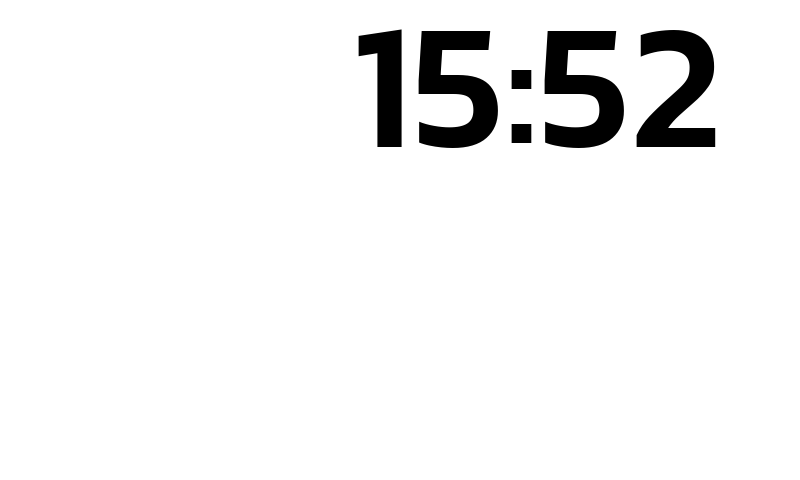

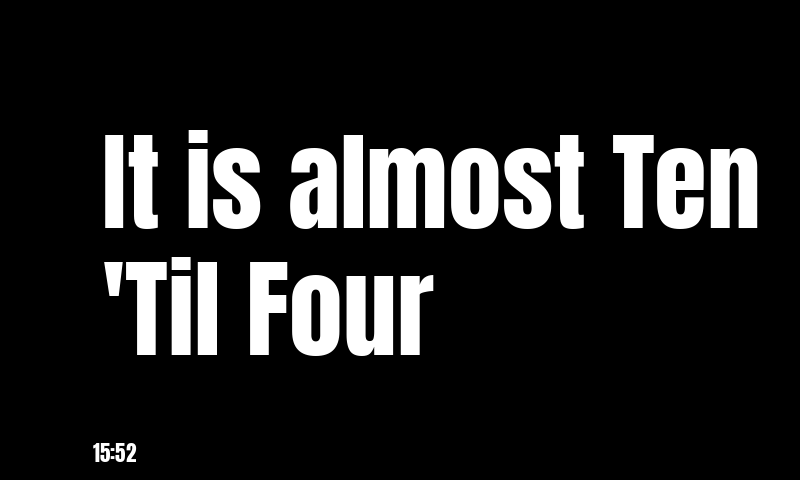

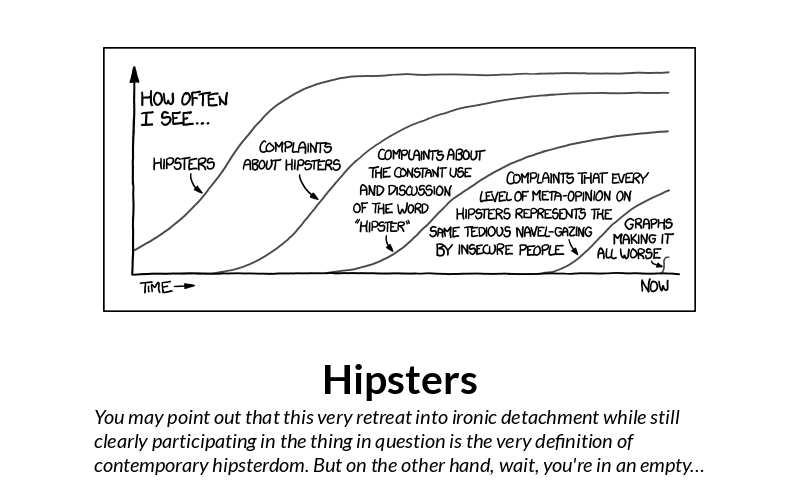

In [47]:
from IPython.display import display
m.update_plugins()
for i in m.active_plugins:
    display(i.image)

In [18]:

m.active_plugins[0].uuid

'31265f78'

In [ ]:
m.active_plugins[2].name
dir(m.active_plugins[2])